Here we visualize filters and outputs using the network architecture proposed by Krizhevsky et al. for ImageNet and implemented in `caffe`.

(This page follows DeCAF visualizations originally by Yangqing Jia.)

First, import required modules, set plotting parameters, and run `./scripts/download_model_binary.py models/bvlc_reference_caffenet` to get the pretrained CaffeNet model if it hasn't already been fetched.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

# Make sure that caffe is on the python path:
caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Set Caffe to CPU mode, load the net in the test phase for inference, and configure input preprocessing.

In [2]:
caffe.set_mode_cpu()
net = caffe.Net('rcnn_model/deploy.prototxt',
                'rcnn_model/bvlc_reference_caffenet.caffemodel',
                caffe.TEST)

net = caffe.Net('rcnn_model/deploy_nn_background.prototxt',
                'rcnn_model/caffenet_train_background_iter_10000.caffemodel',
                caffe.TEST)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
#transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

Classify the image by reshaping the net for the single input then doing the forward pass.

In [3]:
net.blobs['data'].reshape(1,3,227,227)
pict = caffe.io.load_image('13.jpg')
mean_pict = pict.mean(-1)
pict[:,:,0], pict[:,:,1], pict[:,:,2] = mean_pict, mean_pict, mean_pict
net.blobs['data'].data[...] = transformer.preprocess('data', pict)
out = net.forward()
print out.keys()
#print("Predicted class is #{}.".format(out['fc-rcnn'].argmax()))
print("Predicted class is #{}.".format(out['output'].argmax()))

['output']
Predicted class is #0.


The layer features and their shapes (1 is the batch size, corresponding to the single input image in this example).

In [4]:
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (1, 3, 227, 227)),
 ('conv1', (1, 96, 55, 55)),
 ('pool1', (1, 96, 27, 27)),
 ('norm1', (1, 96, 27, 27)),
 ('conv2', (1, 256, 27, 27)),
 ('pool2', (1, 256, 13, 13)),
 ('norm2', (1, 256, 13, 13)),
 ('conv3', (1, 384, 13, 13)),
 ('conv4', (1, 384, 13, 13)),
 ('conv5', (1, 256, 13, 13)),
 ('pool5', (1, 256, 6, 6)),
 ('fc6', (1, 4096)),
 ('fc7', (1, 4096)),
 ('fc8_VOC', (1, 6)),
 ('output', (1, 6))]

The parameters and their shapes. The parameters are `net.params['name'][0]` while biases are `net.params['name'][1]`.

In [5]:
[(k, v[0].data.shape) for k, v in net.params.items()]

[('conv1', (96, 3, 11, 11)),
 ('conv2', (256, 48, 5, 5)),
 ('conv3', (384, 256, 3, 3)),
 ('conv4', (384, 192, 3, 3)),
 ('conv5', (256, 192, 3, 3)),
 ('fc6', (4096, 9216)),
 ('fc7', (4096, 4096)),
 ('fc8_VOC', (6, 4096))]

Helper functions for visualization

In [6]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0, title = None):
    data -= data.min()
    data /= data.max()
    #
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    #
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    #
    if title is not None:
        plt.title(title)
    #
    plt.imshow(data)
    plt.axis('off')
    #
    if title is not None:
        plt.savefig(title + '.png', dpi = 300)
        plt.close()

The input image

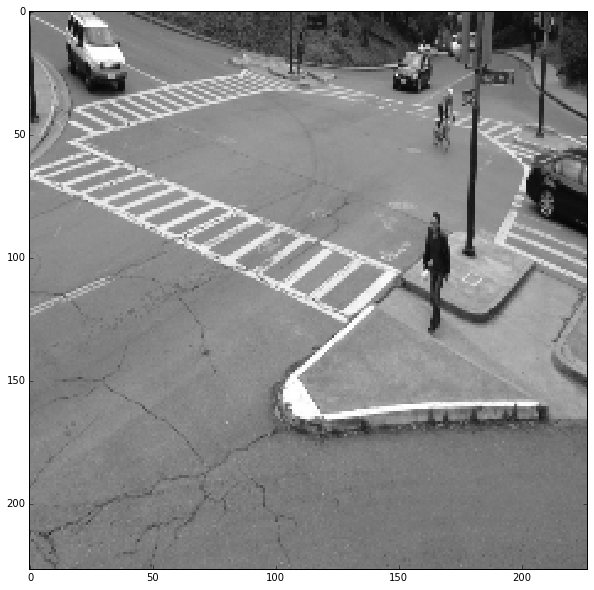

In [7]:
plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))

In [8]:
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1), title = 'Conv1 layer kernels')

In [9]:
filters = net.params['conv2'][0].data
vis_square(filters[:48].reshape(48**2, 5, 5), title = 'Conv 2 layer kernels')

In [10]:
layer_names = net.blobs.keys()
print layer_names
layers_of_interest = ['norm1', 'norm2', 'conv3', 'conv4', 'pool5']
for layer_name in layers_of_interest:
    print net.blobs[layer_name].data.shape
    
for name in layers_of_interest:
    feat = net.blobs[name].data[0]
    vis_square(feat, padval=1, title = 'Activation in layer ' + str(name))

['data', 'conv1', 'pool1', 'norm1', 'conv2', 'pool2', 'norm2', 'conv3', 'conv4', 'conv5', 'pool5', 'fc6', 'fc7', 'fc8_VOC', 'output']
(1, 96, 27, 27)
(1, 256, 13, 13)
(1, 384, 13, 13)
(1, 384, 13, 13)
(1, 256, 6, 6)


In [11]:
from scipy.interpolate import Rbf

def stack_features(net, input_name, target_name):
    target_layer  = net.blobs[target_name]
    n_target_feats = target_layer.data.shape[1]
    #
    desired_shape = net.blobs[input_name].data.shape[-2:]
    current_shape = net.blobs[target_name].data.shape[-2:]
    result = np.zeros((n_target_feats, desired_shape[0], desired_shape[1]))
    #
    t_h = current_shape[0]
    t_w = current_shape[1]
    x, y = np.mgrid[-1:1:1j*t_h, -1:1:1j*t_w]
    #
    new_t_h = desired_shape[0]
    new_t_w = desired_shape[1]
    x_new, y_new = np.mgrid[-1:1:1j*new_t_h,-1:1:1j*new_t_w]
    #
    for target_feat in xrange(n_target_feats):
        z = target_layer.data[0,target_feat,:,:]
        rbf = Rbf(x, y, z, epsilon=0.5)
        result[target_feat,:,:] = rbf(x_new, y_new)
    return result

In [12]:
feat = net.blobs['norm2'].data[0]
#vis_square(feat, padval=1)

In [59]:
input_name    = 'norm1'
layers_of_interest = ['norm1', 'norm2', 'conv3', 'conv4', 'pool5']

stacked_feats = [stack_features(net, input_name, target_name) for target_name in layers_of_interest]

stacked_feats = np.vstack(stacked_feats)

print stacked_feats.shape

#vis_square(stacked_feats, padval=1)

(1376, 27, 27)


In [14]:
"""

from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering

import scipy.sparse as sparse
import time

print stacked_feats.shape

stacked_feats_t = np.transpose(stacked_feats, (1, 2, 0))

print stacked_feats.shape

h = stacked_feats_t.shape[0]
w = stacked_feats_t.shape[1]
d = stacked_feats_t.shape[2]

flat_feats = np.reshape(stacked_feats_t, (h * w, d))

# Convert the image into a graph
graph = image.grid_to_graph(n_x = h, n_y = w)

non_zero_indices = zip(*graph.nonzero())

for idx, (i,j) in enumerate(non_zero_indices):
    graph.data[idx] = np.mean((flat_feats[i] - flat_feats[j]) ** 2)

#beta = 1e-2
#eps = 1e-3
#graph.data = np.exp(- beta * graph.data / flat_feats.var()) + eps

N_REGIONS = 8

for assign_labels in ('kmeans', 'discretize'):
    t0 = time.time()
    labels = spectral_clustering(graph, n_clusters=N_REGIONS,
                                 assign_labels=assign_labels)
    t1 = time.time()
    labels = labels.reshape((h, w))
    plt.figure(figsize=(5, 5))
    plt.imshow(labels, cmap=plt.cm.gray)
    for l in range(N_REGIONS):
        plt.contour(labels == l, contours=1,
                    colors=[plt.cm.spectral(l / float(N_REGIONS)), ])
    plt.xticks(())
    plt.yticks(())
    plt.title('Spectral clustering: %s, %.2fs' % (assign_labels, (t1 - t0)))
    
"""

"\n\nfrom sklearn.feature_extraction import image\nfrom sklearn.cluster import spectral_clustering\n\nimport scipy.sparse as sparse\nimport time\n\nprint stacked_feats.shape\n\nstacked_feats_t = np.transpose(stacked_feats, (1, 2, 0))\n\nprint stacked_feats.shape\n\nh = stacked_feats_t.shape[0]\nw = stacked_feats_t.shape[1]\nd = stacked_feats_t.shape[2]\n\nflat_feats = np.reshape(stacked_feats_t, (h * w, d))\n\n# Convert the image into a graph\ngraph = image.grid_to_graph(n_x = h, n_y = w)\n\nnon_zero_indices = zip(*graph.nonzero())\n\nfor idx, (i,j) in enumerate(non_zero_indices):\n    graph.data[idx] = np.mean((flat_feats[i] - flat_feats[j]) ** 2)\n\n#beta = 1e-2\n#eps = 1e-3\n#graph.data = np.exp(- beta * graph.data / flat_feats.var()) + eps\n\nN_REGIONS = 8\n\nfor assign_labels in ('kmeans', 'discretize'):\n    t0 = time.time()\n    labels = spectral_clustering(graph, n_clusters=N_REGIONS,\n                                 assign_labels=assign_labels)\n    t1 = time.time()\n    labe

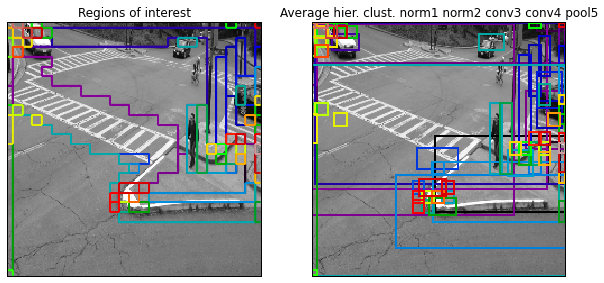

In [60]:
from sklearn.feature_extraction import image
from sklearn.cluster import AgglomerativeClustering
import scipy
import cv2
import matplotlib.patches as patches

stacked_feats_t = np.transpose(stacked_feats, (1, 2, 0))

#
# Withen data
#
#stacked_feats_mean = stacked_feats.mean(0).mean(0)
#stacked_feats -= stacked_feats_mean
#stacked_feats_std = np.sqrt(stacked_feats.var(0).var(0))
#stacked_feats /= stacked_feats_std


h = stacked_feats_t.shape[0]
w = stacked_feats_t.shape[1]
d = stacked_feats_t.shape[2]

flat_feats = np.reshape(stacked_feats_t, (h * w, d))

# Convert the image into a graph
graph = image.grid_to_graph(n_x = h, n_y = w)

N_REGIONS = 80
agg_clustering = AgglomerativeClustering(n_clusters=N_REGIONS,
                                         linkage = 'average',
                                         connectivity = graph).fit(flat_feats)

input_image = transformer.deprocess('data', net.blobs['data'].data[0])
image_h = input_image.shape[0]
image_w = input_image.shape[1]

labels = agg_clustering.labels_.reshape((h, w))

labels = np.round(scipy.ndimage.interpolation.zoom(labels, float(image_h) / float(h), order = 0))


context_padding = 0.2

rois = []
plt.subplot(121)
plt.imshow(input_image)
for l in range(N_REGIONS):
    c = plt.cm.spectral(l / float(N_REGIONS))
    plt.contour(labels == l, contours=1,
                colors=[c, ], alpha = 1.0)
plt.xticks(())
plt.yticks(())

plt.title('Regions of interest')
plt.subplot(122)
plt.imshow(input_image)
for l in range(N_REGIONS):
    y_roi, x_roi = np.nonzero(labels == l)
    xmin = np.min(x_roi)
    xmax = np.max(x_roi)
    ymin = np.min(y_roi)
    ymax = np.max(y_roi)
    #
    window_w = xmax - xmin
    window_h = xmax - xmin
    #
    xmin = int(max(0, xmin - context_padding * window_w))
    xmax = int(min(image_w, xmax + context_padding * window_w))
    ymin = int(max(0, ymin - context_padding * window_h))
    ymax = int(min(image_h, ymax + context_padding * window_h))    
    #
    rois.append([xmin, xmax, ymin, ymax])
    #
    c = plt.cm.spectral(l / float(N_REGIONS))
    coords = (xmin, ymin), xmax - xmin, ymax - ymin
    currentAxis = plt.gca()
    currentAxis.add_patch(plt.Rectangle(*coords, fill = False, edgecolor = c, linewidth = 2))
plt.xticks(())
plt.yticks(())
plt.title('Average hier. clust. ' + ' '.join(layers_of_interest))


plt.savefig('H_clustering.png', dpi = 300)

In [46]:
'''
Created on May 1, 2015

    Hybrid NN for featurization / SVM or other for classification
    The topmost classifier is called the ``head''.

@author: Francois Belletti
'''

import numpy as np
import sklearn as sk
import caffe
import cPickle as pickle

caffe.set_mode_cpu()

class Hybrid_classifier:
    
    #
    #    Instantiates caffe model and head classifier
    #    @param model_filepath     String path to caffe model prototxt
    #    @param weight_filepath    String path to model's weights
    #    @param head_filepath      String path to shallow featurizer
    #    @param label_lookup       String path to label lookup table
    #    @param mean_path          String path to mean image
    def __init__(self, model_filepath, 
                 weight_filepath,
                 head_filepath = None, 
                 label_lookup = None,
                 mean_path = 'ilsvrc_2012_mean.npy',
                 context_pad = 16):
        #    Setup neural net
        self.net            =   caffe.Net(model_filepath, weight_filepath, caffe.TEST)
        #    Setup ``head'' if needed
        if head_filepath is not None:
            self.head           =   pickle.load(open(head_filepath, 'rb'))
        else:
            self.head           =   None
        #    Setup label lookup table if needed
        if label_lookup is not None:
            self.label_to_num   =   pickle.load(open(label_lookup, 'rb'))
            self.num_to_label   =   dict(zip(self.label_to_num.values(), self.label_to_num.keys()))
        else:
            self.label_to_num   =   None
            self.num_to_label   =   None
        #    Setup image transformations
        self.mean_image     =   np.load(mean_path)
        self.transformer    =   caffe.io.Transformer({'data': self.net.blobs['data'].data.shape})
        self.transformer.set_mean('data', np.load(mean_path).mean(1).mean(1))
        self.transformer.set_transpose('data', (2,0,1))
        self.transformer.set_channel_swap('data', (2,1,0))
        self.transformer.set_raw_scale('data', 255.0)
        self.context_pad = context_pad
        self.configure_crop(context_pad)
    
    #
    #    Featurize a given image, works with a file path or an image
    #
    def featurize(self, input_image, target_layers = ['fc7']):
        if type(input_image) is str:
            im = caffe.io.load_image(input_image)
            out = self.net.forward_all(target_layers, 
                                       data = np.asarray([self.transformer.preprocess('data', im)]))
        else:
            out = self.net.forward_all(target_layers, 
                                       data = np.asarray([self.transformer.preprocess('data', input_image)]))
        return [out[x] for x in target_layers]
    
    #
    #    Classify a given image, works with a file path or an image
    #
    def classify_with_head(self, input_image, target_feature, log_probas = False):
        target_layers = [target_feature]
        if type(input_image) is str:
            im  = caffe.io.load_image(input_image)
            out = self.featurize(im, target_layers)
        else:
            out = self.featurize(input_image, target_layers)
        feature_vect = out[0]
        if not log_probas:
            return self.head.predict(feature_vect)
        else:
            return self.head.predict_proba(feature_vect)
        
    def classify_pure_NN(self, input_image, log_probas = False):
        out = self.net.forward_all(data = np.asarray([self.transformer.preprocess('data', input_image)]))
        probas = out.values()[-1]
        if log_probas:
            return np.log(probas)
        else:
            return np.argmax(probas)
        
    def classify(self, input_image, log_probas = False, target_feature = None):
        if self.head is not None:
            return self.classify_with_head(input_image, target_feature, log_probas)
        else:
            return self.classify_pure_NN(input_image, log_probas)
        
    def classify_windows(self, image, windows, feature_layer = 'fc7'):
        """
        Do windowed detection over given images and windows. Windows are
        extracted then warped to the input dimensions of the net.

        Take
        images_windows: (image filename, window list) iterable.
        context_crop: size of context border to crop in pixels.

        Give
        detections: list of {filename: image filename, window: crop coordinates,
            predictions: prediction vector} dicts.
        """
        # Extract windows.
        window_inputs = []
        for window in windows:
            window_inputs.append(self.crop(image, window))

        # Run through the net (warping windows to input dimensions).
        in_ = self.net.inputs[0]
        caffe_in = np.zeros((len(window_inputs), window_inputs[0].shape[2])
                            + self.net.blobs[in_].data.shape[2:],
                            dtype=np.float32)
        for ix, window_in in enumerate(window_inputs):
            caffe_in[ix] = self.transformer.preprocess(in_, window_in)
        if self.head is None:
            out = self.net.forward_all(**{in_: caffe_in})
            #        predictions = out[self.outputs[0]].squeeze(axis=(2,3))
            predictions = out[self.net.outputs[0]].squeeze() # https://github.com/BVLC/caffe/issues/2041
        else:
            out = self.net.forward_all([feature_layer], **{in_: caffe_in})
            #
            feature_vects = out[feature_layer].squeeze()
            #
            predictions = self.head.predict_proba(feature_vects)
            
        # Package predictions with images and windows.
        detections = []
        ix = 0
        for window in windows:
            detections.append({
                'window': window,
                'prediction': predictions[ix],
                'filename': 
            })
            ix += 1
        return detections

        
    def lookup(self, label): 
        if type(label) is str:
            return self.label_to_num[label]
        else:
            return self.num_to_label[int(label)]
        
    def crop(self, im, window):
        """
        Crop a window from the image for detection. Include surrounding context
        according to the `context_pad` configuration.

        Take
        im: H x W x K image ndarray to crop.
        window: bounding box coordinates as ymin, xmin, ymax, xmax.

        Give
        crop: cropped window.
        """
        # Crop window from the image.
        crop = im[window[0]:window[2], window[1]:window[3]]

        if self.context_pad:
            box = window.copy()
            crop_size = self.net.blobs[self.net.inputs[0]].width  # assumes square
            scale = crop_size / (1. * crop_size - self.context_pad * 2)
            # Crop a box + surrounding context.
            half_h = (box[2] - box[0] + 1) / 2.
            half_w = (box[3] - box[1] + 1) / 2.
            center = (box[0] + half_h, box[1] + half_w)
            scaled_dims = scale * np.array((-half_h, -half_w, half_h, half_w))
            box = np.round(np.tile(center, 2) + scaled_dims)
            full_h = box[2] - box[0] + 1
            full_w = box[3] - box[1] + 1
            scale_h = crop_size / full_h
            scale_w = crop_size / full_w
            pad_y = round(max(0, -box[0]) * scale_h)  # amount out-of-bounds
            pad_x = round(max(0, -box[1]) * scale_w)

            # Clip box to image dimensions.
            im_h, im_w = im.shape[:2]
            box = np.clip(box, 0., [im_h, im_w, im_h, im_w])
            clip_h = box[2] - box[0] + 1
            clip_w = box[3] - box[1] + 1
            assert(clip_h > 0 and clip_w > 0)
            crop_h = round(clip_h * scale_h)
            crop_w = round(clip_w * scale_w)
            if pad_y + crop_h > crop_size:
                crop_h = crop_size - pad_y
            if pad_x + crop_w > crop_size:
                crop_w = crop_size - pad_x

            # collect with context padding and place in input
            # with mean padding
            context_crop = im[box[0]:box[2], box[1]:box[3]]
            context_crop = caffe.io.resize_image(context_crop, (crop_h, crop_w))
            crop = np.ones(self.crop_dims, dtype=np.float32) * self.crop_mean
            crop[pad_y:(pad_y + crop_h), pad_x:(pad_x + crop_w)] = context_crop
        #
        return crop
    
    
    def configure_crop(self, context_pad):
        """
        Configure crop dimensions and amount of context for cropping.
        If context is included, make the special input mean for context padding.

        Take
        context_pad: amount of context for cropping.
        """
        # crop dimensions
        in_ = self.net.inputs[0]
        tpose = self.transformer.transpose[in_]
        inv_tpose = [tpose[t] for t in tpose]
        self.crop_dims = np.array(self.net.blobs[in_].data.shape[1:])[inv_tpose]
        #.transpose(inv_tpose)
        # context padding
        self.context_pad = context_pad
        if self.context_pad:
            in_ = self.net.inputs[0]
            transpose = self.transformer.transpose.get(in_)
            channel_order = self.transformer.channel_swap.get(in_)
            raw_scale = self.transformer.raw_scale.get(in_)
            # Padding context crops needs the mean in unprocessed input space.
            mean = self.transformer.mean.get(in_)
            if mean is not None:
                inv_transpose = [transpose[t] for t in transpose]
                crop_mean = mean.copy().transpose(inv_transpose)
                if channel_order is not None:
                    channel_order_inverse = [channel_order.index(i)
                                            for i in range(crop_mean.shape[2])]
                    crop_mean = crop_mean[:,:, channel_order_inverse]
                if raw_scale is not None:
                    crop_mean /= raw_scale
                self.crop_mean = crop_mean
            else:
                self.crop_mean = np.zeros(self.crop_dims, dtype=np.float32)

SyntaxError: invalid syntax (<ipython-input-46-ae23b49d1842>, line 143)

In [53]:
BACKGROUND = True
HYBRID = False

if HYBRID:
    threshold = 0.80
else:
    threshold = 0.99

label_path      = '../image_dump/label_lookup_table.pi'
lookup_table    = pickle.load(open('../image_dump/label_lookup_table.pi', 'rb'))
labels = [x[0] for x in sorted(lookup_table.items(), key = (lambda x : x[1]))]
print labels

hybrid_name = 'forest'

if BACKGROUND:
    # Build detector with our finetuned net
    model_file      = '../finetuning/rcc_net/deploy_nn_background.prototxt'
    model_weights   = '../finetuning/rcc_net/background/caffenet_train_background_iter_10000.caffemodel' 
    mean_image      = '../finetuning/ilsvrc_2012_mean.npy'
    if HYBRID:
        head_path       = '../rcnn_features_ml/%s_fc7_with_bg_model' % hybrid_name
    else:
        hybrid_name = 'NN'
else:
    model_file      = '../finetuning/rcc_net/deploy_nn.prototxt'
    model_weights   = '../finetuning/rcc_net/no_background/caffenet_train_iter_8000.caffemodel' 
    mean_image      = '../finetuning/ilsvrc_2012_mean.npy'
    if HYBRID:
        head_path       = '../rcnn_features_ml/%s_fc7_no_bg_model' % hybrid_name
    else:
        hybrid_name = 'NN'
    labels = labels[1:]

if HYBRID:
    classifier = Hybrid_classifier(model_file,
                                   model_weights,
                                   head_path,
                                   label_lookup = label_path,
                                   mean_path = mean_image)
else:
    classifier = Hybrid_classifier(model_file,
                                   model_weights,
                                   label_lookup = label_path,
                                   mean_path = mean_image)

['background', 'person', 'bicycle', 'bus', 'car', 'motorbike']


In [54]:
import pandas as pd

window_list = np.asarray([[x[2], x[0], x[3], x[1]] for x in rois], dtype = np.int)

detections = classifier.classify_windows(input_image, window_list)

detection_df = pd.DataFrame(detections)

predictions = pd.DataFrame(np.vstack(detection_df.prediction.values), columns = labels)

for label in labels:
    detection_df[label] = predictions[label]

print detection_df

   filename                                         prediction  \
0    image0  [0.992806, 0.00304966, 0.00402025, 1.42278e-05...   
1    image0  [0.999963, 1.23358e-05, 4.76589e-06, 8.49836e-...   
2    image0  [0.203714, 0.675715, 0.000729524, 0.107315, 0....   
3    image0  [1.0, 2.43038e-07, 8.14169e-08, 1.63403e-08, 5...   
4    image0  [0.339566, 0.0015676, 0.00162338, 0.00026917, ...   
5    image0  [0.946755, 0.052457, 0.000162205, 0.000139891,...   
6    image0  [0.841184, 0.073818, 0.00560018, 0.00510033, 0...   
7    image0  [0.990774, 0.000773988, 1.42579e-05, 0.0065562...   
8    image0  [0.999995, 2.81165e-06, 2.21948e-06, 1.58628e-...   
9    image0  [0.999981, 2.5984e-07, 1.5863e-06, 1.38778e-06...   
10   image0  [0.161558, 0.831915, 0.00596134, 0.000300953, ...   
11   image0  [0.000152737, 0.999748, 1.16988e-05, 1.62526e-...   
12   image0  [0.000307327, 0.999662, 3.00542e-05, 6.12069e-...   
13   image0  [0.83305, 0.000865604, 2.00074e-05, 0.130745, ...   
14   image

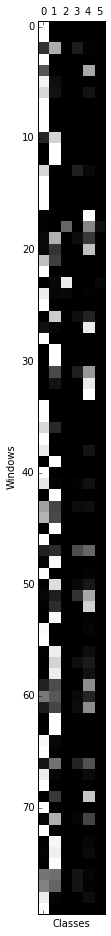

In [55]:
# Activations across windows
plt.gray()
plt.matshow(detection_df[labels].values[:100])
plt.xlabel('Classes')
plt.ylabel('Windows')

In [56]:
# Take maxima across windows
max_s = detection_df[labels].max(0)
max_s.sort(ascending=False)
threshold_dict = dict(zip(max_s.index, max_s.values))
print(max_s[:10])
print threshold_dict

background    1.000000
person        1.000000
car           0.997649
bicycle       0.925664
bus           0.299982
motorbike     0.064692
dtype: float32
{'bicycle': 0.92566359, 'motorbike': 0.064691998, 'bus': 0.2999821, 'person': 0.99999952, 'background': 0.99999964, 'car': 0.99764878}


In [57]:
def show_detections(im, indices, col_name, det_df, object_color = 'r'):
    # Show top detection in red.
    plt.imshow(im)
    currentAxis = plt.gca()
    for i in indices:
        #
        proba  = det_df[col_name][i]
        #
        window = det_df['window'][i]
        #
        ymin = window[0]
        xmin = window[1]
        ymax = window[2]
        xmax = window[3]
        coords = (xmin, ymin), xmax - xmin, ymax - ymin
        #
        currentAxis.add_patch(plt.Rectangle(*coords, fill=True, facecolor = object_color, edgecolor=object_color, linewidth=2, alpha = 0.1 * proba))
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, facecolor = object_color, edgecolor=object_color, linewidth=2, alpha = proba))

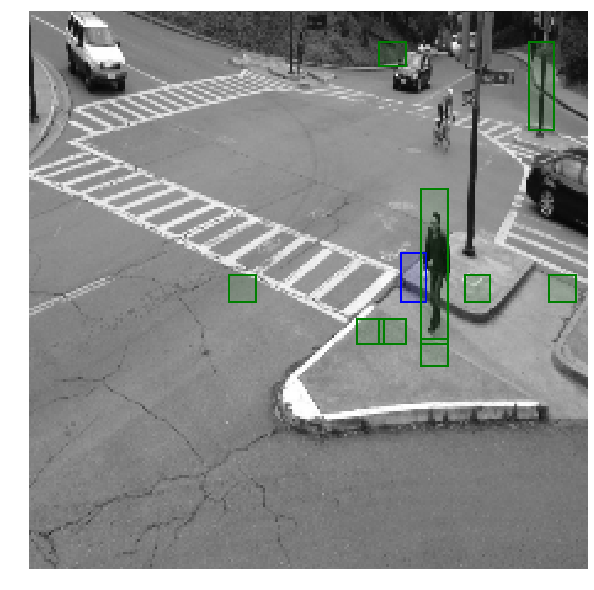

In [58]:
# Find, print, and display the top detections: car
colors = {'car' : 'blue',
          'person' : 'green',
          'bicycle' : 'purple',
          'bus' : 'orange',
          'motorbike' : 'pink'}

#for image_index in range(len(fnames)):
for target_object, object_color in colors.iteritems():
    sub_detection_df = detection_df
    #sub_detection_df = detection_df[detection_df['filename'] == os.path.abspath(fnames[image_index])]
    indices = sub_detection_df[sub_detection_df[target_object] >= threshold].index.get_values()
    #indices = [sub_detection_df[target_object].argmax()]
    #im = plt.imread(fnames[image_index])
    im = input_image
    show_detections(im, indices, target_object, sub_detection_df, object_color)
plt.axis('off')
plt.savefig('Failed neural net segmentation.png', dpi = 300)
#if BACKGROUND:
#    plt.savefig('Multi_detect_%s_background_%s.png' % (hybrid_name, fnames[image_index].split('/')[-1]), dpi = 300)
#else:
#    plt.savefig('Multi_detect_%s_no_background_%s.png' % (hybrid_name, fnames[image_index].split('/')[-1]), dpi = 300)
#plt.show()